# Capstone Project - Which Shoe is the Best for You?

General Assembly passion project. Scrape or obtain data from resources online to develop a dataset to perform cleaning, EDA, and analysis on. Try to predict a model on common themes like: 

- Price
- If item is in category A or B
- Cluster and create groups
- Recommender

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from time import sleep, strftime
import ast
from os import listdir

% matplotlib inline

**Testing one website and finding appropriate keys**

Then run again on page 2.

In [2]:
result = requests.get('https://stockx.com/api/browse?page=1&category=152')
json_res = result.json()

# print json_res['Products'][0]['shortDescription']
# print json_res['Products'][0]['retailPrice']

In [3]:
result = requests.get('https://stockx.com/api/browse?page=2&category=152')
json_res = result.json()

print json_res['Products'][0]['shortDescription']
print json_res['Products'][0]['retailPrice']

Adidas-NMD-R1-Gum-Pack-White
170


In [4]:
json_res['Products'][0]['market']

{u'absChangePercentage': 0.024242,
 u'annualHigh': 318,
 u'annualLow': 130,
 u'averageDeadstockPrice': 223,
 u'averageDeadstockPriceRank': 63,
 u'changePercentage': 0.024242,
 u'changeValue': 4,
 u'createdAt': u'2017-02-02T16:27:02+00:00',
 u'deadstockRangeHigh': 190,
 u'deadstockRangeLow': 148,
 u'deadstockSold': 881,
 u'deadstockSoldRank': 75,
 u'highestBid': 160,
 u'lastHighestBidTime': 1498499435,
 u'lastLowestAskTime': 1498501309,
 u'lastSale': 169,
 u'lastSaleDate': u'2017-06-26T17:59:31+00:00',
 u'lowestAsk': 155,
 u'pricePremium': -0.006,
 u'pricePremiumRank': 96,
 u'productId': 0,
 u'productUuid': u'780d8091-49f6-434a-8575-e6e6ac09191f',
 u'salesLast72Hours': 29,
 u'salesLastPeriod': 0,
 u'salesThisPeriod': 29,
 u'skuUuid': None,
 u'updatedAt': 1498501297,
 u'volatility': 0.122275}

### Functions to run for loop to scrape website

First function scrapes the web for an amount of pages (default 50). It will save the raw data as a csv as well. The second function will then clean the dataframe by taking out the unused columns.

In [5]:
def shoe_scraper(pages=50):
    '''Returns one dataframe of all results. 
    And will save into a new file.'''
    
    # Have to run requests first to get appropriate column names
    req = requests.get('https://stockx.com/api/browse?page=1&category=152')
    json_req = req.json()
    df = pd.DataFrame([], columns=json_req['Products'][0].keys())

    for i in range(1,pages):
        try:
            html = 'https://stockx.com/api/browse?page=' + str(int(i)) + '&category=152'
            result = requests.get(html)
            json_res = result.json()
            df = pd.concat([df, pd.DataFrame(json_res['Products'])])
            sleep(0.5)
        except:
            break
    
    # Drop row duplicates
    df.drop_duplicates(['shortDescription', 'urlKey'], inplace=True) 
    
    # Function to save as csv file under today's day as raw (before dropping)
    def csv_maker(df):
        filename = 'StockX_' + strftime("%m%d%H")
        df.to_csv(path_or_buf='C:\\Users\\Chris\\Desktop\\dsi-atl-3\\project\\Capstone\\datasets\\' + filename, encoding='utf-8')
    
    csv_maker(df)
    
    return df

In [6]:
def clean_df(busy_dataframe):
    '''Dropping columns that hold little to no information.
    Then reset the index since we are getting repeated indices'''
    
    # Market DataFrame. If scraping, comes in ready form
    # If pulling from old data, dictionary comes in string form
    if isinstance(busy_dataframe.market.reset_index(drop=True)[0], str):
        market_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['market']])
    else:
        market_df = pd.DataFrame([row for row in busy_dataframe['market']])
    
    # Drop unnecessary columns
    cleaner_dataframe = busy_dataframe.join(market_df)
    
    cleanest_dataframe = cleaner_dataframe.drop(['breadcrumbs', 'childId', 'countryOfManufacture', 'type', 
        'uuid', 'dataType', 'doppelgangers', 'condition', 'description', 'hidden', 'ipoDate', 'productCategory', 
        'shoeSize', 'urlKey', 'charityCondition', 'releaseTime', 'shortDescription', 'media', '_highlightResult', 
        'market', '_tags', 'id', 'objectID', 'lastHighestBidTime', 'lastLowestAskTime', 'styleId', 'productId',
        'productUuid', 'skuUuid', 'updatedAt', 'traits', 'tickerSymbol', 'salesLastPeriod',
        'minimumBid', 'averageDeadstockPriceRank', 'deadstockSoldRank', 'pricePremium', 'pricePremiumRank'], axis=1)
    
    # Remember title = shoe + name

    # Reset the index, since we are getting repeated indices
    
    cleanest_dataframe.reset_index(drop=True, inplace=True)
    return cleanest_dataframe

In [7]:
scraped_shoe = shoe_scraper()

In [8]:
def read_and_clean(path):
    '''Read a file path where datasets are stored. Cleans the dataframe by
    removing duplicates, removing first column (Unnamed: 0) to be ready for
    clean_df function.'''
    file_list = listdir(path)
    file_list.remove('dataio')
    
    # Make a list of all the dataframes
    parts_df = [pd.read_csv('../datasets/' + files) for files in file_list]
    
    # Make one dataframe, take out first column and drop duplicates based on 'urlkey'
    df = pd.concat(parts_df)
    df = df.iloc[:,1:]
    df.drop_duplicates(['uuid'], inplace=True)
    
    # Clean Brand names
    df.brand = df.brand.map(lambda x: x.title())
    return df

In [9]:
path = '../datasets/'

shoe = clean_df(read_and_clean(path))

In [80]:
shoe = shoe[shoe.retailPrice.notnull()]
shoe.shape

(1614, 26)

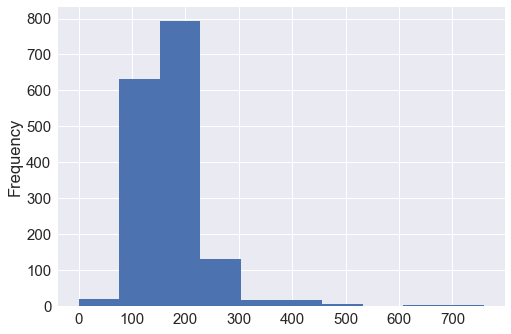

In [81]:
shoe.retailPrice.plot(kind='hist')

In [82]:
shoe[shoe.highestBid == shoe.highestBid.max()][['shoe', 'colorway', 'name', 'highestBid', 'year']]

,shoe,colorway,name,highestBid,year
1383,Adidas Ultra Boost,Adidas-Ultra-Boost-Miami-Hurricanes,Miami Hurricanes,3037,2016.0
1384,Nike Air Max 90,White/White,Laser NYC,3037,2016.0
1385,Jordan 1 Retro Low OG,Ice Blue/Vachetta Tan-White,Ice Blue,3037,2017.0


In [83]:
shoe[shoe.retailPrice == shoe.retailPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year']]

,shoe,colorway,name,retailPrice,year
864,Reebok Instapump Fury,White/Multi-Color,Vetements Doodle,760.0,2017.0


In [84]:
shoe.head(2)

,brand,category,colorway,name,releaseDate,retailPrice,shoe,title,year,absChangePercentage,...,deadstockRangeHigh,deadstockRangeLow,deadstockSold,highestBid,lastSale,lastSaleDate,lowestAsk,salesLast72Hours,salesThisPeriod,volatility
0,Adidas,adidas Yeezy,Core White/Core White/Core White,Calabasas Core White,2017-03-28 23:59:59,120.0,Adidas Yeezy Powerphase,Adidas Yeezy Powerphase Calabasas Core White,2017.0,0.093750,...,185,165,2749,229,175,2017-06-18T19:45:58+00:00,149,916,916,0.059055
1,Adidas,adidas NMD,Core Black/Core Black/Footwear White,OG Black,2017-05-20 23:59:59,150.0,Adidas NMD XR1,Adidas NMD XR1 OG Black,2017.0,0.086957,...,183,117,793,180,150,2017-06-18T16:03:09+00:00,149,133,133,0.217655


In [85]:
tops = shoe[(shoe.brand=='Adidas')|(shoe.brand=='Nike')|(shoe.brand=='Jordan')]

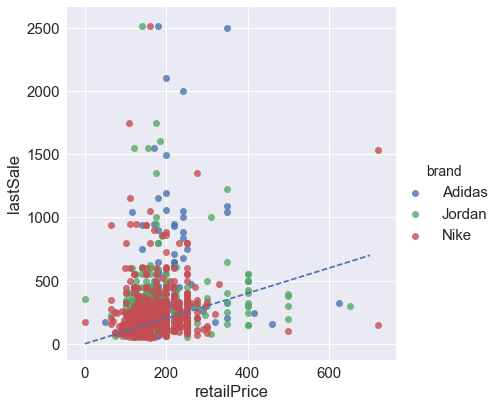

In [86]:
sns.set(font_scale=1.5)
sns.lmplot(x='retailPrice', y ='lastSale', data=tops, hue='brand', fit_reg=False, size=6)
plt.plot(np.linspace(0,700,700), np.linspace(0,700,700), linestyle='--')
plt.show()

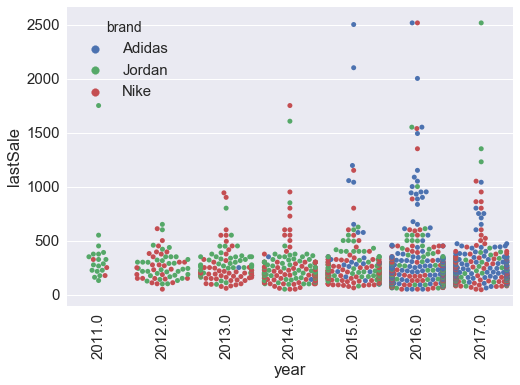

In [87]:
sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2010], hue='brand')
plt.xticks(rotation=90)
plt.show()

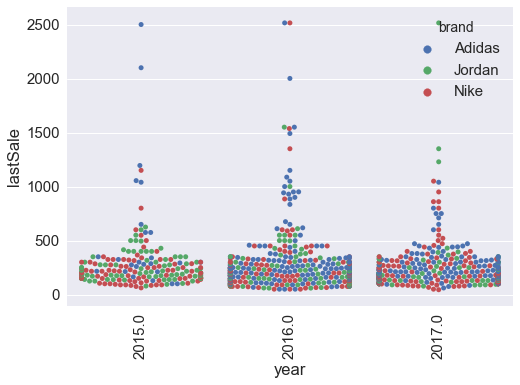

In [88]:
sns.swarmplot(x='year', y='lastSale', data=tops[tops.year>2014], hue='brand')
plt.xticks(rotation=90)
plt.show()

In [91]:
tops[(tops.brand=='Adidas') & (tops.shoe.str.contains('boost', case=False))].shape

(166, 26)

In [92]:
tops[tops.shoe.str.contains('yeezy',case=False)].shape

(27, 26)